In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
shutil.copy2("/content/drive/MyDrive/utilities.py", "/content/utilities.py")
shutil.copy2("/content/drive/MyDrive/ConvNet.py", "/content/ConvNet.py")
shutil.copy2("/content/drive/MyDrive/config.py", "/content/config.py")

'/content/config.py'

In [3]:
import ConvNet
import config
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.data import AUTOTUNE
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import os
import numpy as np
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import MultiLabelBinarizer
from IPython.display import Audio, clear_output, display
from glob import glob
import random
from utilities import acuracia0, acuracia1, acuracia2
import utilities

In [4]:
model = ConvNet.ConvNet

In [ ]:
model.summary()

# DA=0.0

In [ ]:
DA = 0

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_shan_40/aval_shan_40.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_shan_40/training_shan_40_review.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


### Tensors Definitions

In [ ]:
TRAIN_DATASET = os.path.join("/content", "training_shan_40_review")
VAL_DATASET = os.path.join("/content", "COMBINADOS")
#TEST_DATASET = os.path.join("/content", "teste1")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")
METRONOMOS_DATASET_VAL = os.path.join("/content/drive/MyDrive/Database", "metronomos")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)

classes_val = os.listdir(METRONOMOS_DATASET_VAL) 
classes_val = sorted(classes_val)

def make_dataset_aug(path, batch_size, classes_n):
   
    def parse_image_augmented(filename,label):
        if np.random.rand()<=DA:            
            fator = np.random.choice([0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2])            
            fator = fator.astype(np.float32)
            rand_value = tf.constant(fator, dtype=tf.float32)
                        
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)
            
            def f1(): return 1.0
            def f2(): return fator
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator
            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)
                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
        else:
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
        return (image_aug, label_aug)
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    classes_n=classes_n
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [ ]:
print(classes)
print(classes_val)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [ ]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS, classes)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
def make_dataset_simple(path, batch_size, classes_n):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes_n = classes_n #classes de 23 a 257
    classes_n = sorted(classes_n)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes_n,images_ds,labels_ds

In [ ]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS, classes) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS, classes_val) #labels com valores 0 a 234
#testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [ ]:
list_images_train = list(images_train.as_numpy_iterator())

In [ ]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [ ]:
#list_images_test = list(images_test.as_numpy_iterator())

In [ ]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes_val[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

#list_labels_test= list(labels_test.as_numpy_iterator())
#labels_test_true = []
#for i in list_labels_test:
#       labels_test_true.append(classes[i])
#labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [ ]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
#images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
#print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
#print(testDS)

(8728, 40, 256, 1)
(4670, 40, 256, 1)
(8728,)
(4670,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
#print(images_train_ds[1])

In [ ]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [ ]:
%%time
history = model.fit(trainDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
137/137 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.2656966086159487
Train - Acurácia 2:  0.5816911090742438
73/73 [==============================] - 3s 46ms/step
Validation - Acurácia 0:  0.08715203426124198
validation - Acurácia 2:  0.4019271948608137
137/137 [==============================] - 36s 160ms/step - loss: 3.9805 - accuracy: 0.1959
Epoch 2/50
137/137 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.35620989917506873
Train - Acurácia 2:  0.720096241979835
73/73 [==============================] - 3s 35ms/step
Validation - Acurácia 0:  0.12141327623126338
validation - Acurácia 2:  0.4970021413276231
137/137 [==============================] - 19s 141ms/step - loss: 2.7953 - accuracy: 0.3438
Epoch 3/50
137/137 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.391269477543538
Train - Acurácia 2:  0.7820806599450045
73/73 [==============================] - 3s 35ms/step
Validation - Acurácia 0:  0.1468

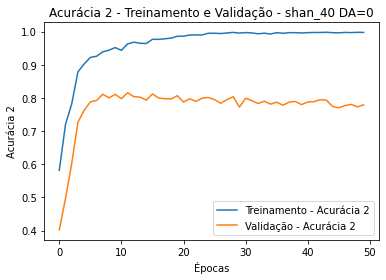

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - shan_40 DA=0')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/shan_40_da/acc2_'+'da0'+'.pdf', format='pdf')
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/Resultados/shan_40_da/acc2_'+'da0',acc)
np.save('/content/drive/MyDrive/Resultados/shan_40_da/val_acc2_'+'da0',val_acc)

In [ ]:
model.save('/content/drive/MyDrive/Resultados/shan_40_da/shan_40_da0')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/shan_40_da/shan_40_da0')

### Training Results

In [ ]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

137/137 [==============================] - 5s 35ms/step
(8728, 140)
(8728,)
(8728,)


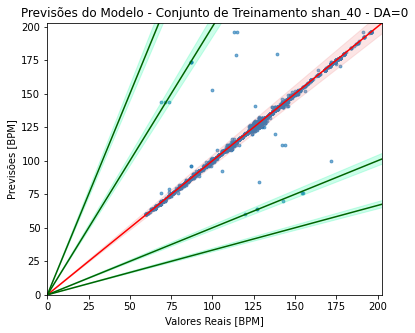

In [ ]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento shan_40 - DA=0', '/content/drive/MyDrive/Resultados/shan_40_da/prev_train_'+'da0'+'.pdf')

In [ ]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_shan_40_da0'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

         Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_shan_40_da0    0.930683    0.996334     0.997709


### Validation Results

In [ ]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

73/73 [==============================] - 3s 35ms/step
(4670, 140)
(4670, 140)
(4670,)
(4670,)


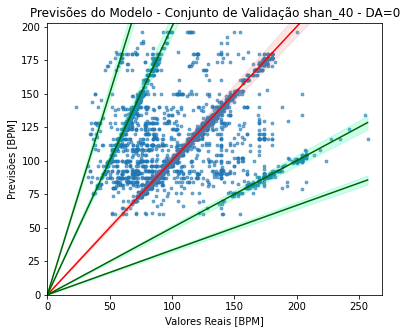

In [ ]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação shan_40 - DA=0', '/content/drive/MyDrive/Resultados/shan_40_da/prev_validation_'+'da0'+'.pdf')

In [ ]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_shan_40_da0'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

              Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_40_da0    0.930683    0.996334     0.997709
1  validation_shan_40_da0    0.231906    0.584368     0.779443


In [ ]:
resultados.to_excel("/content/drive/MyDrive/Resultados/shan_40_da/Resultados_shan_40_da0.xlsx", index=False)  

In [ ]:
from google.colab import runtime
runtime.unassign()

# DA=0.25

In [5]:
# DA = 0.25

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_shan_40/aval_shan_40.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_shan_40/training_shan_40_review.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


### Tensors Definitions

In [6]:
TRAIN_DATASET = os.path.join("/content", "training_shan_40_review")
VAL_DATASET = os.path.join("/content", "COMBINADOS")
#TEST_DATASET = os.path.join("/content", "teste1")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")
METRONOMOS_DATASET_VAL = os.path.join("/content/drive/MyDrive/Database", "metronomos")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)

classes_val = os.listdir(METRONOMOS_DATASET_VAL) 
classes_val = sorted(classes_val)

def make_dataset_aug(path, batch_size, classes_n):
   
    def parse_image_augmented(filename,label):
        primeiro_rand_value = tf.random.uniform((),minval=0.01, maxval=0.99)
        DA = tf.constant(0.25, dtype=tf.float32)   #### IMPORTANTE. ALTERAR O VALOR DA CONSTANTE DE DATA AUGMENTATION
        tf_cond0 = tf.math.less_equal(primeiro_rand_value,DA)
        def func_a():            
            a = tf.random.uniform((),minval=0.08, maxval=0.12)
            b = tf.constant(100, dtype=tf.float32)
            c = tf.multiply(a,b)
            c = tf.math.round(c)
            d = tf.constant(10, dtype=tf.float32)
            rand_value = tf.math.divide(c,d)                    
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)            
            def f1(): return 1.0
            def f2(): return rand_value
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
            return image_aug, label_aug
        def func_b():
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
            return image_aug, label_aug
        image_aug, label_aug = tf.cond(tf_cond0, func_a, func_b)
        return image_aug, label_aug
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    classes_n=classes_n
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [7]:
print(classes)
print(classes_val)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [8]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS, classes)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
def make_dataset_simple(path, batch_size, classes_n):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes_n = classes_n #classes de 23 a 257
    classes_n = sorted(classes_n)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes_n,images_ds,labels_ds

In [10]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS, classes) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS, classes_val) #labels com valores 0 a 234
#testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [11]:
list_images_train = list(images_train.as_numpy_iterator())

In [12]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [ ]:
#list_images_test = list(images_test.as_numpy_iterator())

In [13]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes_val[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

#list_labels_test= list(labels_test.as_numpy_iterator())
#labels_test_true = []
#for i in list_labels_test:
#       labels_test_true.append(classes[i])
#labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [14]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
#images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
#print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
#print(testDS)

(8728, 40, 256, 1)
(4670, 40, 256, 1)
(8728,)
(4670,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
#print(images_train_ds[1])

In [15]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [16]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [17]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [18]:
%%time
history = model.fit(trainAugDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
137/137 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.23258478460128323
Train - Acurácia 2:  0.5391842346471127
73/73 [==============================] - 3s 45ms/step
Validation - Acurácia 0:  0.08394004282655246
validation - Acurácia 2:  0.3507494646680942
137/137 [==============================] - 35s 159ms/step - loss: 3.8134 - accuracy: 0.2180
Epoch 2/50
137/137 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.36858386801099907
Train - Acurácia 2:  0.7632905591200734
73/73 [==============================] - 2s 34ms/step
Validation - Acurácia 0:  0.13768736616702357
validation - Acurácia 2:  0.5471092077087795
137/137 [==============================] - 19s 139ms/step - loss: 2.8587 - accuracy: 0.3225
Epoch 3/50
137/137 [==============================] - 5s 34ms/step
Train - Acurácia 0:  0.44615032080659944
Train - Acurácia 2:  0.8680109990834097
73/73 [==============================] - 3s 34ms/step
Validation - Acurácia 0:  0.

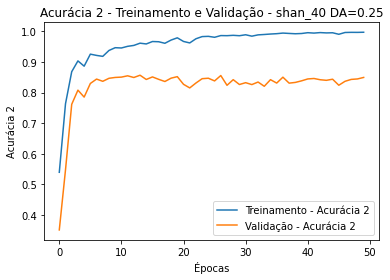

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - shan_40 DA=0.25')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/shan_40_da/acc2_'+'da025'+'.pdf', format='pdf')
plt.show()

In [20]:
np.save('/content/drive/MyDrive/Resultados/shan_40_da/acc2_'+'da025',acc)
np.save('/content/drive/MyDrive/Resultados/shan_40_da/val_acc2_'+'da025',val_acc)

In [21]:
model.save('/content/drive/MyDrive/Resultados/shan_40_da/shan_40_da025')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/shan_40_da/shan_40_da025')

### Training Results

In [22]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

137/137 [==============================] - 5s 35ms/step
(8728, 140)
(8728,)
(8728,)


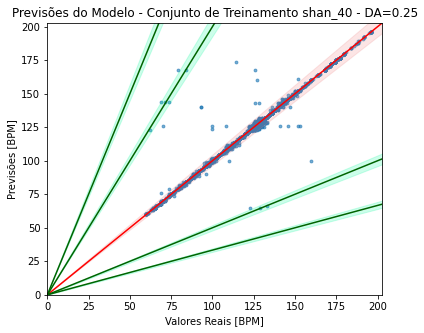

In [23]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento shan_40 - DA=0.25', '/content/drive/MyDrive/Resultados/shan_40_da/prev_train_'+'da025'+'.pdf')

In [24]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_shan_40_da025'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

           Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_shan_40_da025    0.931599    0.996334     0.997021


### Validation Results

In [25]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

73/73 [==============================] - 3s 35ms/step
(4670, 140)
(4670, 140)
(4670,)
(4670,)


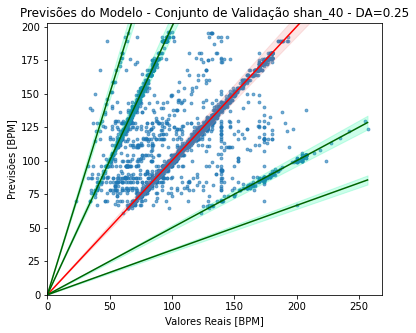

In [26]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação shan_40 - DA=0.25', '/content/drive/MyDrive/Resultados/shan_40_da/prev_validation_'+'da025'+'.pdf')

In [27]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_shan_40_da025'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

                Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_40_da025    0.931599    0.996334     0.997021
1  validation_shan_40_da025    0.270236    0.617345     0.849251


In [28]:
resultados.to_excel("/content/drive/MyDrive/Resultados/shan_40_da/Resultados_shan_40_da025.xlsx", index=False)  

In [29]:
from google.colab import runtime
runtime.unassign()

# DA=0.5

In [5]:
#DA = 0.5

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_shan_40/aval_shan_40.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_shan_40/training_shan_40_review.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


### Tensors Definitions

In [6]:
TRAIN_DATASET = os.path.join("/content", "training_shan_40_review")
VAL_DATASET = os.path.join("/content", "COMBINADOS")
#TEST_DATASET = os.path.join("/content", "teste1")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")
METRONOMOS_DATASET_VAL = os.path.join("/content/drive/MyDrive/Database", "metronomos")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)

classes_val = os.listdir(METRONOMOS_DATASET_VAL) 
classes_val = sorted(classes_val)

def make_dataset_aug(path, batch_size, classes_n):
   
    def parse_image_augmented(filename,label):
        primeiro_rand_value = tf.random.uniform((),minval=0.01, maxval=0.99)
        DA = tf.constant(0.5, dtype=tf.float32)   #### IMPORTANTE. ALTERAR O VALOR DA CONSTANTE DE DATA AUGMENTATION
        tf_cond0 = tf.math.less_equal(primeiro_rand_value,DA)
        def func_a():            
            a = tf.random.uniform((),minval=0.08, maxval=0.12)
            b = tf.constant(100, dtype=tf.float32)
            c = tf.multiply(a,b)
            c = tf.math.round(c)
            d = tf.constant(10, dtype=tf.float32)
            rand_value = tf.math.divide(c,d)                    
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)            
            def f1(): return 1.0
            def f2(): return rand_value
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
            return image_aug, label_aug
        def func_b():
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
            return image_aug, label_aug
        image_aug, label_aug = tf.cond(tf_cond0, func_a, func_b)
        return image_aug, label_aug
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    classes_n=classes_n
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [7]:
print(classes)
print(classes_val)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [8]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS, classes)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
def make_dataset_simple(path, batch_size, classes_n):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes_n = classes_n #classes de 23 a 257
    classes_n = sorted(classes_n)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes_n,images_ds,labels_ds

In [10]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS, classes) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS, classes_val) #labels com valores 0 a 234
#testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [11]:
list_images_train = list(images_train.as_numpy_iterator())

In [12]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [ ]:
#list_images_test = list(images_test.as_numpy_iterator())

In [13]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes_val[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

#list_labels_test= list(labels_test.as_numpy_iterator())
#labels_test_true = []
#for i in list_labels_test:
#       labels_test_true.append(classes[i])
#labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [14]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
#images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
#print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
#print(testDS)

(8728, 40, 256, 1)
(4670, 40, 256, 1)
(8728,)
(4670,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
#print(images_train_ds[1])

In [15]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [16]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [17]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [18]:
%%time
history = model.fit(trainAugDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
137/137 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.23201191567369386
Train - Acurácia 2:  0.5367781851512374
73/73 [==============================] - 3s 46ms/step
Validation - Acurácia 0:  0.07794432548179872
validation - Acurácia 2:  0.3468950749464668
137/137 [==============================] - 36s 159ms/step - loss: 4.5280 - accuracy: 0.0983
Epoch 2/50
137/137 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.23109532538955088
Train - Acurácia 2:  0.6425297891842346
73/73 [==============================] - 3s 35ms/step
Validation - Acurácia 0:  0.09507494646680942
validation - Acurácia 2:  0.47301927194860816
137/137 [==============================] - 19s 140ms/step - loss: 3.2828 - accuracy: 0.2580
Epoch 3/50
137/137 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.3890925756186984
Train - Acurácia 2:  0.8172548120989918
73/73 [==============================] - 3s 35ms/step
Validation - Acurácia 0:  0.

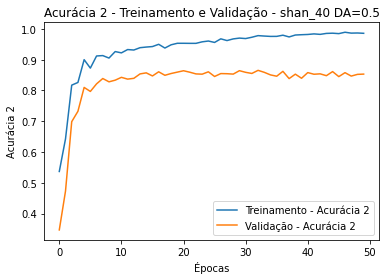

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - shan_40 DA=0.5')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/shan_40_da/acc2_'+'da05'+'.pdf', format='pdf')
plt.show()

In [20]:
np.save('/content/drive/MyDrive/Resultados/shan_40_da/acc2_'+'da05',acc)
np.save('/content/drive/MyDrive/Resultados/shan_40_da/val_acc2_'+'da05',val_acc)

In [21]:
model.save('/content/drive/MyDrive/Resultados/shan_40_da/shan_40_da05')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/shan_40_da/shan_40_da05')

### Training Results

In [22]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

137/137 [==============================] - 5s 35ms/step
(8728, 140)
(8728,)
(8728,)


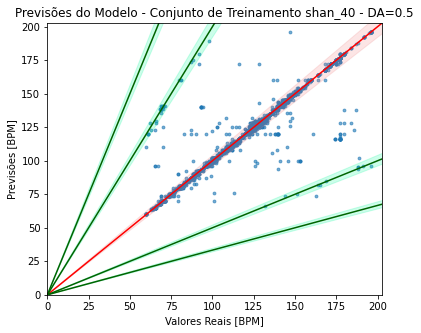

In [23]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento shan_40 - DA=0.5', '/content/drive/MyDrive/Resultados/shan_40_da/prev_train_'+'da05'+'.pdf')

In [24]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_shan_40_da05'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

          Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_shan_40_da05    0.846471    0.980981     0.985678


### Validation Results

In [25]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

73/73 [==============================] - 3s 35ms/step
(4670, 140)
(4670, 140)
(4670,)
(4670,)


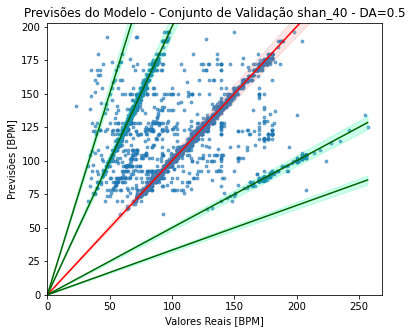

In [26]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação shan_40 - DA=0.5', '/content/drive/MyDrive/Resultados/shan_40_da/prev_validation_'+'da05'+'.pdf')

In [27]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_shan_40_da05'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

               Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_40_da05    0.846471    0.980981     0.985678
1  validation_shan_40_da05    0.271520    0.627409     0.853105


In [28]:
resultados.to_excel("/content/drive/MyDrive/Resultados/shan_40_da/Resultados_shan_40_da05.xlsx", index=False)  

In [ ]:
from google.colab import runtime
runtime.unassign()

# DA=0.75

In [5]:
#DA = 0.75

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_shan_40/aval_shan_40.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_shan_40/training_shan_40_review.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


### Tensors Definitions

In [6]:
TRAIN_DATASET = os.path.join("/content", "training_shan_40_review")
VAL_DATASET = os.path.join("/content", "COMBINADOS")
#TEST_DATASET = os.path.join("/content", "teste1")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")
METRONOMOS_DATASET_VAL = os.path.join("/content/drive/MyDrive/Database", "metronomos")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)

classes_val = os.listdir(METRONOMOS_DATASET_VAL) 
classes_val = sorted(classes_val)

def make_dataset_aug(path, batch_size, classes_n):
   
    def parse_image_augmented(filename,label):
        primeiro_rand_value = tf.random.uniform((),minval=0.01, maxval=0.99)
        DA = tf.constant(0.75, dtype=tf.float32)   #### IMPORTANTE. ALTERAR O VALOR DA CONSTANTE DE DATA AUGMENTATION
        tf_cond0 = tf.math.less_equal(primeiro_rand_value,DA)
        def func_a():            
            a = tf.random.uniform((),minval=0.08, maxval=0.12)
            b = tf.constant(100, dtype=tf.float32)
            c = tf.multiply(a,b)
            c = tf.math.round(c)
            d = tf.constant(10, dtype=tf.float32)
            rand_value = tf.math.divide(c,d)                    
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)            
            def f1(): return 1.0
            def f2(): return rand_value
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
            return image_aug, label_aug
        def func_b():
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
            return image_aug, label_aug
        image_aug, label_aug = tf.cond(tf_cond0, func_a, func_b)
        return image_aug, label_aug
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    classes_n=classes_n
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [7]:
print(classes)
print(classes_val)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [8]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS, classes)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
def make_dataset_simple(path, batch_size, classes_n):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes_n = classes_n #classes de 23 a 257
    classes_n = sorted(classes_n)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes_n,images_ds,labels_ds

In [10]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS, classes) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS, classes_val) #labels com valores 0 a 234
#testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [11]:
list_images_train = list(images_train.as_numpy_iterator())

In [12]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [ ]:
#list_images_test = list(images_test.as_numpy_iterator())

In [13]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes_val[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

#list_labels_test= list(labels_test.as_numpy_iterator())
#labels_test_true = []
#for i in list_labels_test:
#       labels_test_true.append(classes[i])
#labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [14]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
#images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
#print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
#print(testDS)

(8728, 40, 256, 1)
(4670, 40, 256, 1)
(8728,)
(4670,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
#print(images_train_ds[1])

In [15]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [16]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [17]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [18]:
%%time
history = model.fit(trainAugDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
137/137 [==============================] - 5s 34ms/step
Train - Acurácia 0:  0.2819660861594867
Train - Acurácia 2:  0.6536434463794684
73/73 [==============================] - 3s 46ms/step
Validation - Acurácia 0:  0.10535331905781585
validation - Acurácia 2:  0.4843683083511777
137/137 [==============================] - 36s 158ms/step - loss: 4.0382 - accuracy: 0.1662
Epoch 2/50
137/137 [==============================] - 5s 34ms/step
Train - Acurácia 0:  0.38049954170485795
Train - Acurácia 2:  0.8186296975252062
73/73 [==============================] - 3s 34ms/step
Validation - Acurácia 0:  0.18179871520342614
validation - Acurácia 2:  0.7381156316916488
137/137 [==============================] - 19s 138ms/step - loss: 2.9391 - accuracy: 0.2941
Epoch 3/50
137/137 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.4375572868927589
Train - Acurácia 2:  0.8564390467461045
73/73 [==============================] - 3s 35ms/step
Validation - Acurácia 0:  0.20

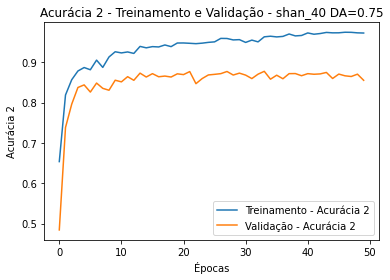

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - shan_40 DA=0.75')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/shan_40_da/acc2_'+'da075'+'.pdf', format='pdf')
plt.show()

In [20]:
np.save('/content/drive/MyDrive/Resultados/shan_40_da/acc2_'+'da075',acc)
np.save('/content/drive/MyDrive/Resultados/shan_40_da/val_acc2_'+'da075',val_acc)

In [21]:
model.save('/content/drive/MyDrive/Resultados/shan_40_da/shan_40_da075')

In [22]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/shan_40_da/shan_40_da075')

### Training Results

In [23]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

137/137 [==============================] - 5s 35ms/step
(8728, 140)
(8728,)
(8728,)


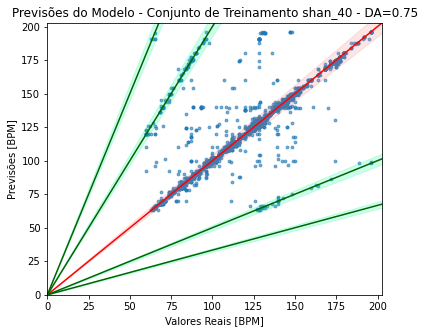

In [24]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento shan_40 - DA=0.75', '/content/drive/MyDrive/Resultados/shan_40_da/prev_train_'+'da075'+'.pdf')

In [25]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_shan_40_da075'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

           Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_shan_40_da075    0.736022    0.958295     0.972159


### Validation Results

In [26]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

73/73 [==============================] - 3s 35ms/step
(4670, 140)
(4670, 140)
(4670,)
(4670,)


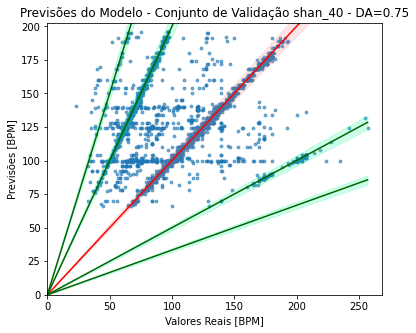

In [27]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação shan_40 - DA=0.75', '/content/drive/MyDrive/Resultados/shan_40_da/prev_validation_'+'da075'+'.pdf')

In [28]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_shan_40_da075'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

                Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_40_da075    0.736022    0.958295     0.972159
1  validation_shan_40_da075    0.278801    0.599358     0.855032


In [ ]:
resultados.to_excel("/content/drive/MyDrive/Resultados/shan_40_da/Resultados_shan_40_da075.xlsx", index=False)  

In [ ]:
from google.colab import runtime
runtime.unassign()

# DA=1.0

In [5]:
#DA = 1.0

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_shan_40/aval_shan_40.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_shan_40/training_shan_40_review.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


### Tensors Definitions

In [6]:
TRAIN_DATASET = os.path.join("/content", "training_shan_40_review")
VAL_DATASET = os.path.join("/content", "COMBINADOS")
#TEST_DATASET = os.path.join("/content", "teste1")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")
METRONOMOS_DATASET_VAL = os.path.join("/content/drive/MyDrive/Database", "metronomos")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)

classes_val = os.listdir(METRONOMOS_DATASET_VAL) 
classes_val = sorted(classes_val)

def make_dataset_aug(path, batch_size, classes_n):
   
    def parse_image_augmented(filename,label):
        primeiro_rand_value = tf.random.uniform((),minval=0.01, maxval=0.99)
        DA = tf.constant(1.0, dtype=tf.float32)   #### IMPORTANTE. ALTERAR O VALOR DA CONSTANTE DE DATA AUGMENTATION
        tf_cond0 = tf.math.less_equal(primeiro_rand_value,DA)
        def func_a():            
            a = tf.random.uniform((),minval=0.08, maxval=0.12)
            b = tf.constant(100, dtype=tf.float32)
            c = tf.multiply(a,b)
            c = tf.math.round(c)
            d = tf.constant(10, dtype=tf.float32)
            rand_value = tf.math.divide(c,d)                    
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)            
            def f1(): return 1.0
            def f2(): return rand_value
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
            return image_aug, label_aug
        def func_b():
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
            return image_aug, label_aug
        image_aug, label_aug = tf.cond(tf_cond0, func_a, func_b)
        return image_aug, label_aug
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    classes_n=classes_n
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [7]:
print(classes)
print(classes_val)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [8]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS, classes)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
def make_dataset_simple(path, batch_size, classes_n):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes_n = classes_n #classes de 23 a 257
    classes_n = sorted(classes_n)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes_n,images_ds,labels_ds

In [10]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS, classes) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS, classes_val) #labels com valores 0 a 234
#testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [11]:
list_images_train = list(images_train.as_numpy_iterator())

In [12]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [ ]:
#list_images_test = list(images_test.as_numpy_iterator())

In [13]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes_val[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

#list_labels_test= list(labels_test.as_numpy_iterator())
#labels_test_true = []
#for i in list_labels_test:
#       labels_test_true.append(classes[i])
#labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [14]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
#images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
#print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
#print(testDS)

(8728, 40, 256, 1)
(4670, 40, 256, 1)
(8728,)
(4670,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
#print(images_train_ds[1])

In [15]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [16]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [17]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [18]:
%%time
history = model.fit(trainAugDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
137/137 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.15547662694775435
Train - Acurácia 2:  0.3839367552703941
73/73 [==============================] - 3s 46ms/step
Validation - Acurácia 0:  0.0715203426124197
validation - Acurácia 2:  0.31306209850107064
137/137 [==============================] - 36s 160ms/step - loss: 4.2721 - accuracy: 0.1226
Epoch 2/50
137/137 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.20863886342804766
Train - Acurácia 2:  0.6605178735105408
73/73 [==============================] - 3s 35ms/step
Validation - Acurácia 0:  0.13040685224839402
validation - Acurácia 2:  0.6436830835117773
137/137 [==============================] - 19s 140ms/step - loss: 3.1577 - accuracy: 0.2518
Epoch 3/50
137/137 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.32974335472044
Train - Acurácia 2:  0.7447296058661779
73/73 [==============================] - 3s 35ms/step
Validation - Acurácia 0:  0.188

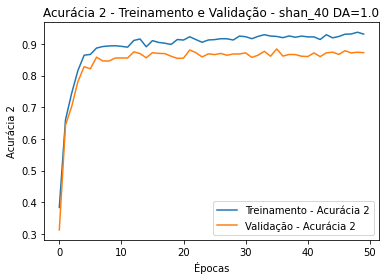

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - shan_40 DA=1.0')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/shan_40_da/acc2_'+'da1'+'.pdf', format='pdf')
plt.show()

In [20]:
np.save('/content/drive/MyDrive/Resultados/shan_40_da/acc2_'+'da1',acc)
np.save('/content/drive/MyDrive/Resultados/shan_40_da/val_acc2_'+'da1',val_acc)

In [21]:
model.save('/content/drive/MyDrive/Resultados/shan_40_da/shan_40_da1')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/shan_40_da/shan_40_da1')

### Training Results

In [22]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

137/137 [==============================] - 5s 35ms/step
(8728, 140)
(8728,)
(8728,)


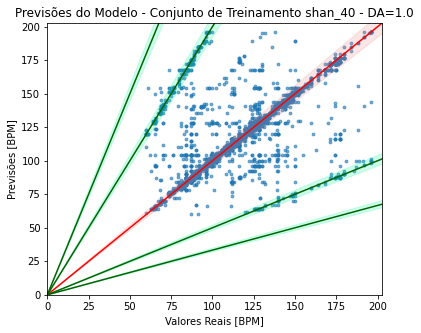

In [23]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento shan_40 - DA=1.0', '/content/drive/MyDrive/Resultados/shan_40_da/prev_train_'+'da1'+'.pdf')

In [24]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_shan_40_da1'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

         Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_shan_40_da1    0.552475    0.895394     0.930912


### Validation Results

In [25]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

73/73 [==============================] - 3s 35ms/step
(4670, 140)
(4670, 140)
(4670,)
(4670,)


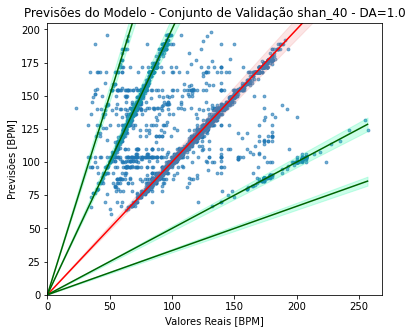

In [26]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação shan_40 - DA=1.0', '/content/drive/MyDrive/Resultados/shan_40_da/prev_validation_'+'da1'+'.pdf')

In [27]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_shan_40_da1'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

              Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_shan_40_da1    0.552475    0.895394     0.930912
1  validation_shan_40_da1    0.270664    0.614133     0.872163


In [28]:
resultados.to_excel("/content/drive/MyDrive/Resultados/shan_40_da/Resultados_shan_40_da1.xlsx", index=False)  

In [29]:
from google.colab import runtime
runtime.unassign()